In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from datasetcontroller.datacontroller import DataController
# import tensorflow as tf
# from nnmodules.unet import Unet_v2
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
import numpy as np

2023-06-16 12:22:51.689799: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-16 12:22:51.726926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from flax import linen as nn
from flax.training import train_state
import jax
from jax import lax, random, numpy as jnp
import numpy as np
import optax

In [3]:
from rasterio.transform import from_origin
import rasterio
from rasterio.plot import show

In [4]:
def local_get_ctp_based_pred_map(datacontroller, pred_arr, vmin_val,vmax_val, title_name, ax):
    data = pred_arr 
    # 배열 크기
    height, width, bands = data.shape

    # 레스터 파일 생성
    dst_filename = os.path.join(datacontroller._data_path,"output.tif")  # 저장할 레스터 파일 경로와 이름 설정
    driver = 'GTiff'  # 레스터 파일 포맷 (여기서는 GeoTIFF로 설정)

    # 레스터 파일 매개변수 설정
    transform = from_origin(-180000, 153000, 9000, 9000)  # 좌표변환을 위한 transform 설정 (여기서는 임의로 설정)
    # transform = from_origin(153000, -180000, 9000, 9000)  # 좌표변환을 위한 transform 설정 (여기서는 임의로 설정)
    count = bands  # 밴드 개수
    dtype = data.dtype  # 데이터 타입

    # 레스터 파일 생성 및 데이터 쓰기
    with rasterio.open(dst_filename, 'w', driver=driver, height=height, width=width, count=count, dtype=dtype, transform=transform) as dst:
        for band in range(bands):
            dst.write(data[:, :, band], band + 1)
    

    with rasterio.open(dst_filename) as src:

        # fig, ax = plt.subplots(figsize=(6, 6))
        plt.title(title_name)
        data = src.read(1)
        # 컬러바
        image = ax.imshow(data, vmin=vmin_val, vmax=vmax_val, cmap='cividis')
        cbar = plt.colorbar(image, ax=ax,)
        # cbar = plt.colorbar(colormapping2, ax=ax,)

        # # 진짜 그리기
        image = show(src, ax=ax, vmin=vmin_val, vmax=vmax_val, cmap='cividis')
        datacontroller._ctp_rvn_gpd_cutting.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.2)
         

In [5]:
class Upsample(nn.Module):
  features: int

  def setup(self):
      self.layers = [
         nn.Conv(self.features,(3,3),strides=None),
         nn.BatchNorm(use_running_average=False),
         nn.Conv(self.features,(3,3),strides=None),
         nn.BatchNorm(use_running_average=False),
         nn.ConvTranspose(self.features,(3,3),strides=(2,2))
        ]
      

  # @nn.compact
  def __call__(self, x):
    for layer in self.layers:
            x = layer(x)

    return x
  
class Downsample(nn.Module):
  features: int

  def setup(self):
      self.layers = [
         nn.Conv(self.features,(3,3),strides=None),
         nn.BatchNorm(use_running_average=False),
         nn.Conv(self.features,(3,3),strides=None),
         nn.BatchNorm(use_running_average=False),
        ]

  # @nn.compact
  def __call__(self, x):
    for layer in self.layers:
            x = layer(x)

    x = nn.max_pool(x,(2,2),strides=(2,2), padding='VALID')


    return x
  
class UNET(nn.Module):

    def setup(self):

      self.down_stack = [
            Downsample(128),  # (batch_size, 64, 64, 64)
            Downsample(256),  # (batch_size, 32, 32, 128)
            Downsample(512),  # (batch_size, 16, 16, 256)
            Downsample(512),  # (batch_size, 8, 8, 512)
            Downsample(512),  # (batch_size, 4, 4, 512)
        ]
      
      self.up_stack = [
            Upsample(512),  # (batch_size, 4, 4, 1024)
            Upsample(512),  # (batch_size, 8, 8, 1024)
            Upsample(256),  # (batch_size, 16, 16, 512)
            Upsample(128),  # (batch_size, 32, 32, 256)
            Upsample(64),  # (batch_size, 64, 64, 128)
        ]
      
      self.out_layer_1 = nn.ConvTranspose(64,(3,3),strides=(2,2))
      self.out_layer_2 = nn.Conv(1,(3,3),strides=None)

    # @nn.compact
    def __call__(self, x):
        
        

        # Downsampling through the model
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)
           
        skips = reversed(skips[:-1])

        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            
            x = jnp.concatenate([x, skip], axis=-1)
  
        x = self.out_layer_1(x)
        x = self.out_layer_2(x)

        return x

In [6]:
BATCH_SIZE = 16
train_set_len = 100
shuffle_buffer_size = 100

In [7]:
# set dataset path
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# get controller
datacontroller = DataController(data_path = data_path)

# control matrix, smoke, cmaq 
control_matrix, smoke_arr, target_arr = datacontroller.get_yearly_dataset()

# 학습용셋
train_input = smoke_arr[:train_set_len]
test_input = smoke_arr[train_set_len:]

train_output = target_arr[:train_set_len]
test_output = target_arr[train_set_len:]

# train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
# train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

# test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
# test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)


# train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
# test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)


/usr/local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


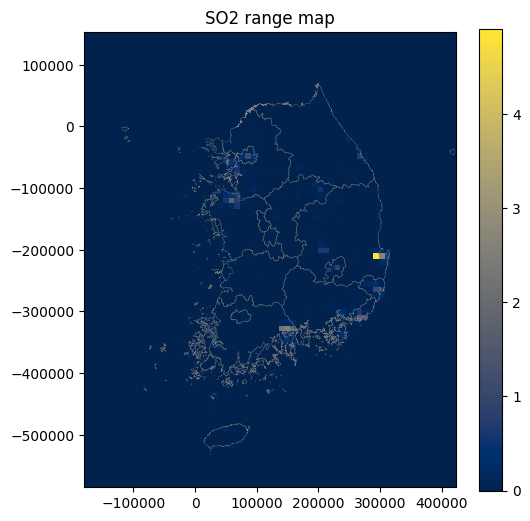

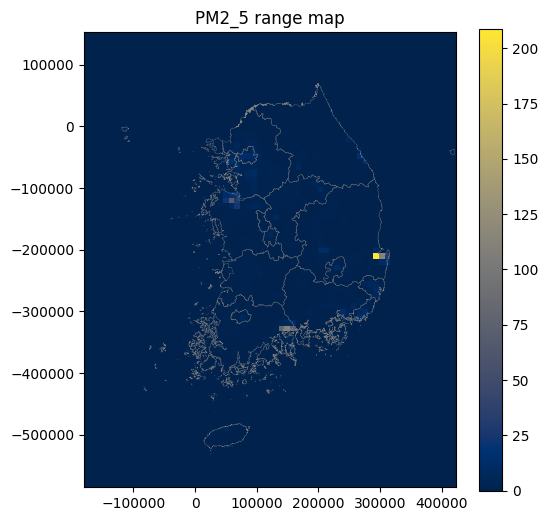

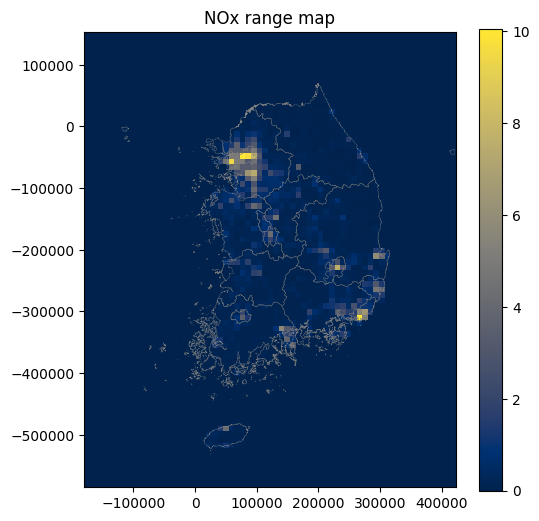

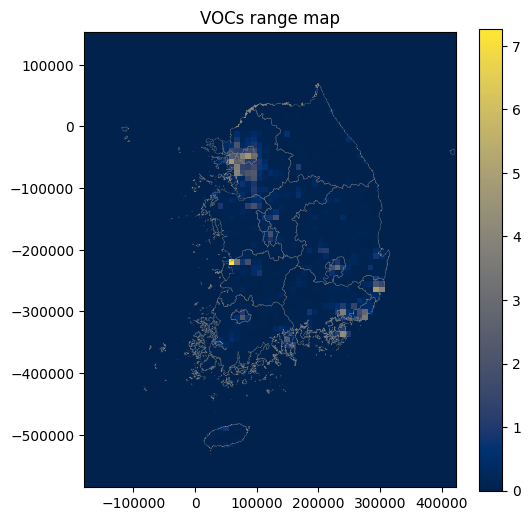

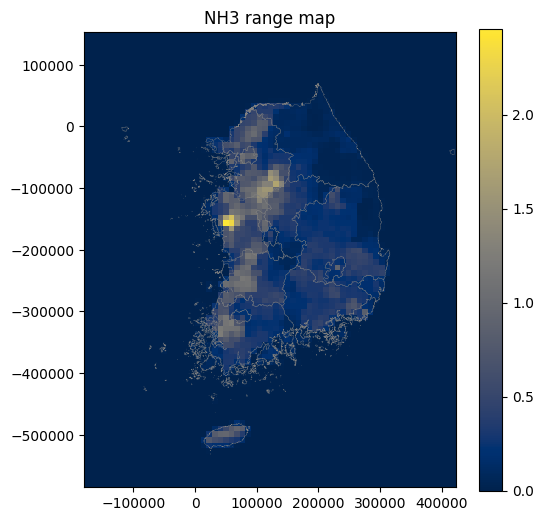

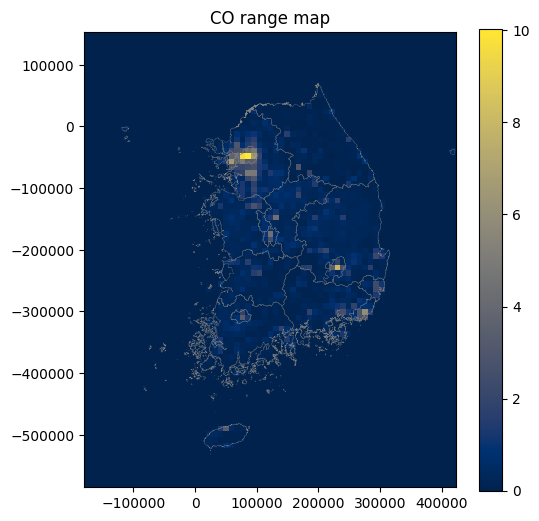

In [8]:
for i, chem in enumerate(datacontroller._smoke_chem_list):
    fig, ax = plt.subplots(figsize=(6, 6))
    max_array = np.max(smoke_arr[:,:,:,i].reshape(120,-1),axis=0)
    min_array = np.min(smoke_arr[:,:,:,i].reshape(120,-1),axis=0)
    resid_array = max_array - min_array
    std_array = np.std(smoke_arr[:,:,:,i].reshape(120,-1),axis=0)
    datacontroller.get_ctp_based_pred_map(resid_array.reshape(82,67,1)[::-1],min(resid_array),max(resid_array), chem + ' range map',ax)

In [9]:
%%time
@jax.jit
def apply_model(state, x_batched, y_batched):
  """Computes gradients, loss and accuracy for a single batch."""
  def loss_fn(params, x_batched, y_batched):

    pred = state.apply_fn(params, x_batched, mutable=["batch_stats"])[0]
    pred = jax.image.resize(pred, (pred.shape[0], 82,67,1), method="nearest")

    l2_losses = optax.l2_loss(y_batched,pred)
    mse_loss = jnp.mean(l2_losses)

    return mse_loss

  grad_fn = jax.value_and_grad(loss_fn)
  loss_val, grads = grad_fn(state.params, x_batched, y_batched)
  return grads, loss_val

@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

train_input = jax.image.resize(train_input, (train_input.shape[0], 128,128,6), method="nearest")
test_input = jax.image.resize(test_input, (test_input.shape[0], 128,128,6), method="nearest")

model = UNET()
key = random.PRNGKey(0)
input_dim = train_input.shape[1:]
params = model.init(key, jnp.ones(input_dim))

CPU times: user 13 s, sys: 1.21 s, total: 14.2 s
Wall time: 18.2 s


In [13]:
import tensorflow as tf
train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)


train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)



lr = 0.0001
steps = 3000
tx = optax.adam(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():

    input_arr = jax.image.resize(jnp.array(input_arr.numpy()), (input_arr.shape[0], 128,128,6), method="nearest")

    grads, loss_val = apply_model(state, input_arr, target.numpy())
    state = update_model(state, grads)
    print(f"\r step: {step}, mse_loss: {loss_val}", end = "")

lr = 0.00001
steps = 3000
tx = optax.adam(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply, params=state.params, tx=tx)

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():

    input_arr = jax.image.resize(jnp.array(input_arr.numpy()), (input_arr.shape[0], 128,128,6), method="nearest")

    grads, loss_val = apply_model(state, input_arr, target.numpy())
    state = update_model(state, grads)
    print(f"\r step: {step}, mse_loss: {loss_val}", end = "")

2023-06-16 12:26:42.504368: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-06-16 12:26:42.518604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype float and shape [100,82,67,1]
	 [[{{node Placeholder/_6}}]]
2023-06-16 12:26:42.518875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype float and shape [100,82,67,1]
	 [[{{node Placeholder/_6}}]]


 step: 2999, mse_loss: 0.0087905926629900934

2023-06-16 12:30:04.599415: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-06-16 12:30:04.613556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype float and shape [100,128,128,6]
	 [[{{node Placeholder/_4}}]]
2023-06-16 12:30:04.613817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype float and shape [100,128,128,6]
	 [[{{node Placeholder/_4}}]]


 step: 2999, mse_loss: 0.0012931235833093524

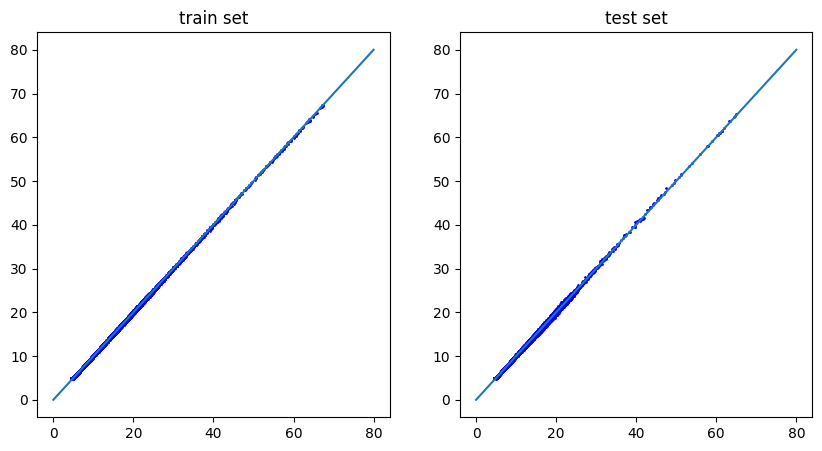

In [14]:
def predict(state, inputs):
  pred = state.apply_fn(state.params, inputs, mutable=["batch_stats"])[0]
  pred = jax.image.resize(pred, (pred.shape[0], 82,67,1), method="nearest")
  return pred


pred_train = predict(state, train_input)
pred_test = predict(state, test_input)

plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.title('train set')
plt.plot(pred_train.reshape(-1), train_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

plt.subplot(1,2,2)
plt.title('test set')
plt.plot(pred_test.reshape(-1), test_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

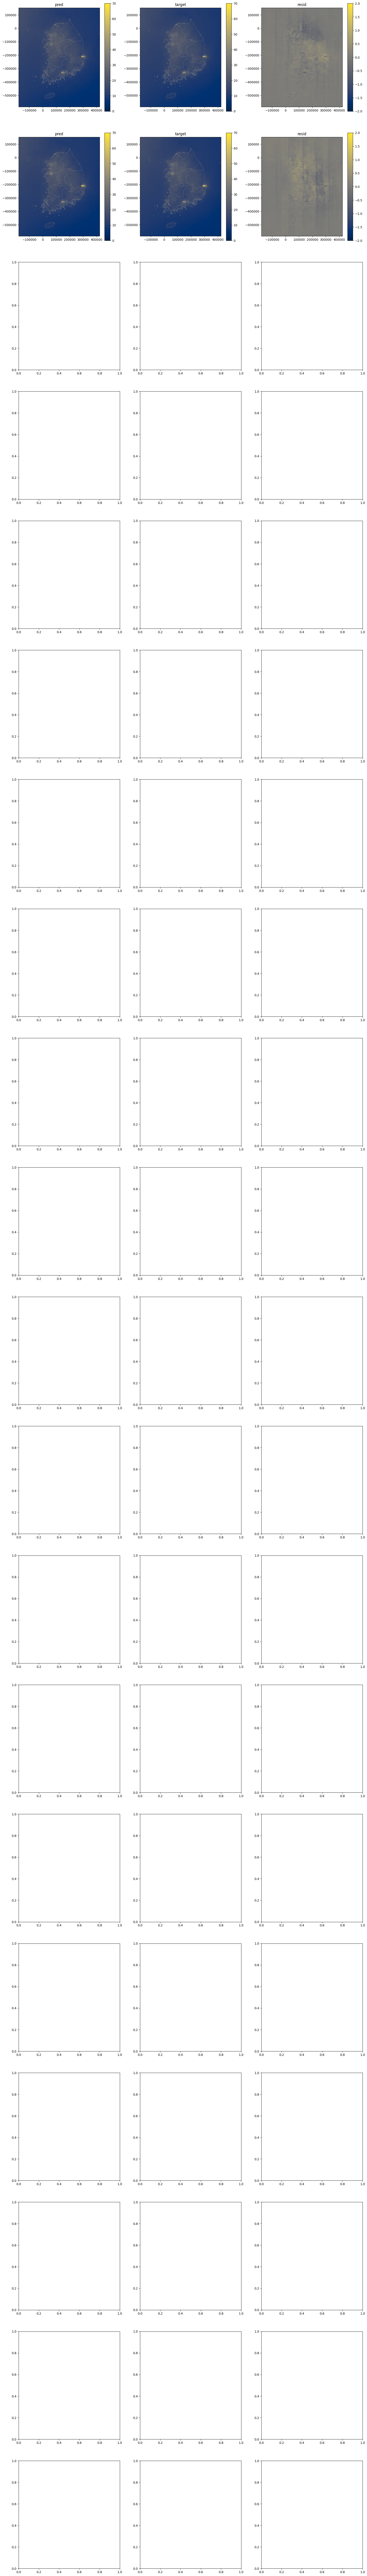

In [15]:
# plt.figure(figsize = [10,100])

fig,ax=plt.subplots(20,3)
fig.set_figheight(150)
fig.set_figwidth(20)

for i in range(len(pred_test))[:2]:
    datacontroller.get_ctp_based_pred_map(pred_test[i][::-1],0,70,'pred', ax = ax[i,0])
    datacontroller.get_ctp_based_pred_map(test_output[i][::-1],0,70,'target', ax = ax[i,1])
    datacontroller.get_ctp_based_pred_map(pred_test[i][::-1] - test_output[i][::-1],-2,2,'resid', ax = ax[i,2])
    
    

    

In [16]:
def r_square(y_true, y_pred):
    SS_res = np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_pred)))
    return (1-SS_res / SS_tot)
# In[]
def NME(y_true, y_pred):
    return (np.sum( abs( (y_pred - y_true) / y_true ) ) / len(y_pred))*100

In [17]:
r_sq = []

for i in range(len(test_input)):
    r_sq.append(r_square(pred_test[i][::-1].reshape(-1), test_output[i][::-1].reshape(-1)))

print(np.mean(r_sq),np.std(r_sq),np.min(r_sq))

0.9992719901754754 0.00045204655094712224 0.9976685030851513


(1.2761586, 0.6049547, 0.19356397)

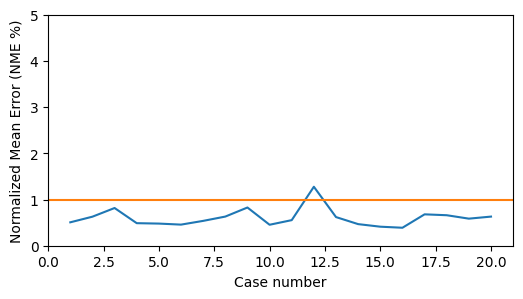

In [18]:
# In[]
result = []
                                                                                                                                                                                                                                                                                                                      
for i in range(len(test_input)):
    result.append(NME(pred_test[i][::-1].reshape(-1), test_output[i][::-1].reshape(-1)))
    
# In[]
plt.figure(figsize=(6,3))
plt.plot(np.arange(1,len(test_input)+1,1), np.array(result))
plt.xlim([0,len(test_input)+1])
plt.ylim([0,5])
plt.plot([0,len(test_input)+1],[1,1])
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')
# In[]
np.max(result), np.mean(result), np.std(result)

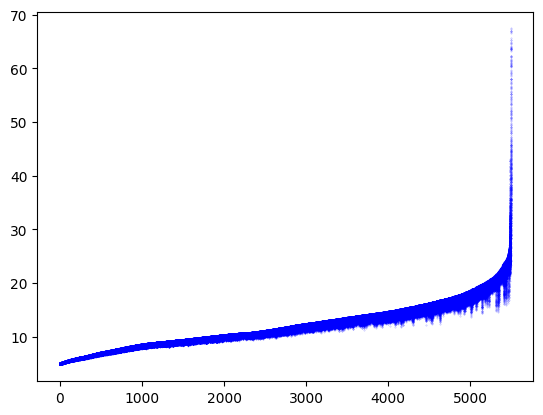

In [19]:
max_array = np.max(target_arr.reshape(120,-1),axis=0)
min_array = np.min(target_arr.reshape(120,-1),axis=0)
resid_array = max_array - min_array
std_array = np.std(target_arr.reshape(120,-1),axis=0)
sort_ind = max_array.argsort()

for i in range(len(target_arr)):
    plt.scatter(range(target_arr.shape[1] * target_arr.shape[2]), target_arr[i].reshape(-1)[sort_ind], color = 'blue', alpha = 0.3, s = 0.1)

plt.show()

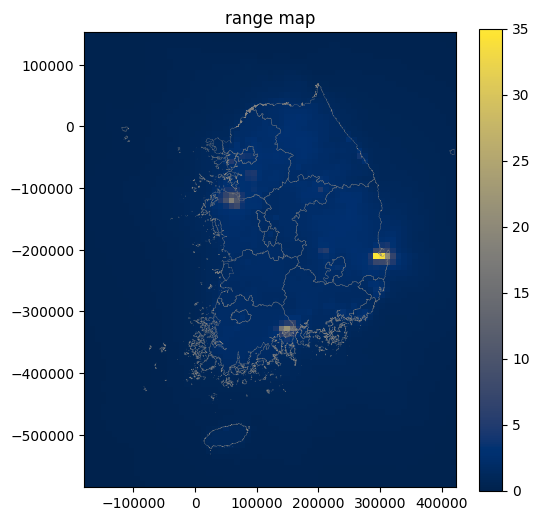

In [25]:
plot1 = datacontroller.get_ctp_based_pred_map(resid_array.reshape(82,67,1)[::-1],0,35,'range map')

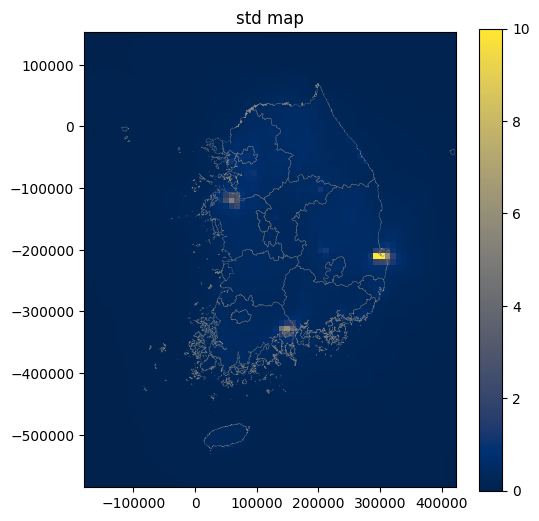

In [26]:
plot2 = datacontroller.get_ctp_based_pred_map(std_array.reshape(82,67,1)[::-1],0,10,'std map')

In [38]:
std_array.reshape(82,67,1).shape

(82, 67, 1)

* 부트스트랩 저장